In [7]:
from pyspark.sql import SparkSession, Row, functions as F
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
from pyspark.ml.feature import Tokenizer, CountVectorizer, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
spark = SparkSession.builder \
    .appName("Sentiment Analysis") \
    .config("spark.jars.packages", 
            "org.apache.spark:spark-mllib_2.12:3.3.0,org.postgresql:postgresql:42.2.25") \
    .getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


# URL JDBC pour PostgreSQL
jdbc_url = "jdbc:postgresql://192.168.1.24:5442/postgres"

# Propriétés JDBC
jdbc_properties = {
    "user": "postgres",
    "password": "test2021",
    "driver": "org.postgresql.Driver"
}

# Sentiment Distribution: Bar chart showing the number of positive, negative, and neutral tweets/toots.

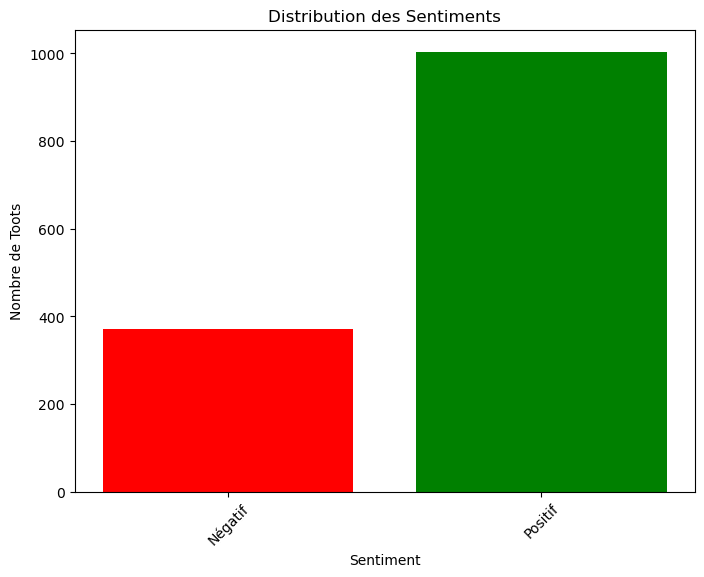

In [18]:
# Lire les résultats depuis PostgreSQL
results_df = spark.read.jdbc(url=jdbc_url, table="sentiment_results", properties=jdbc_properties)

# Compter le nombre de prédictions pour chaque sentiment
sentiment_counts = results_df.groupBy("prediction").count().toPandas()

# Définir les étiquettes pour le graphique
sentiment_labels = {0: "Négatif", 1: "Positif", 2: "Neutre"}
sentiment_counts["prediction"] = sentiment_counts["prediction"].replace(sentiment_labels)

# Créer le graphique
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts["prediction"], sentiment_counts["count"], color=['red', 'green', 'yellow'])
plt.xlabel("Sentiment")
plt.ylabel("Nombre de Toots")
plt.title("Distribution des Sentiments")
plt.xticks(rotation=45)
plt.show()

# Toot Frequency: Line chart showing the number of toots over time (e.g., per hour/day).

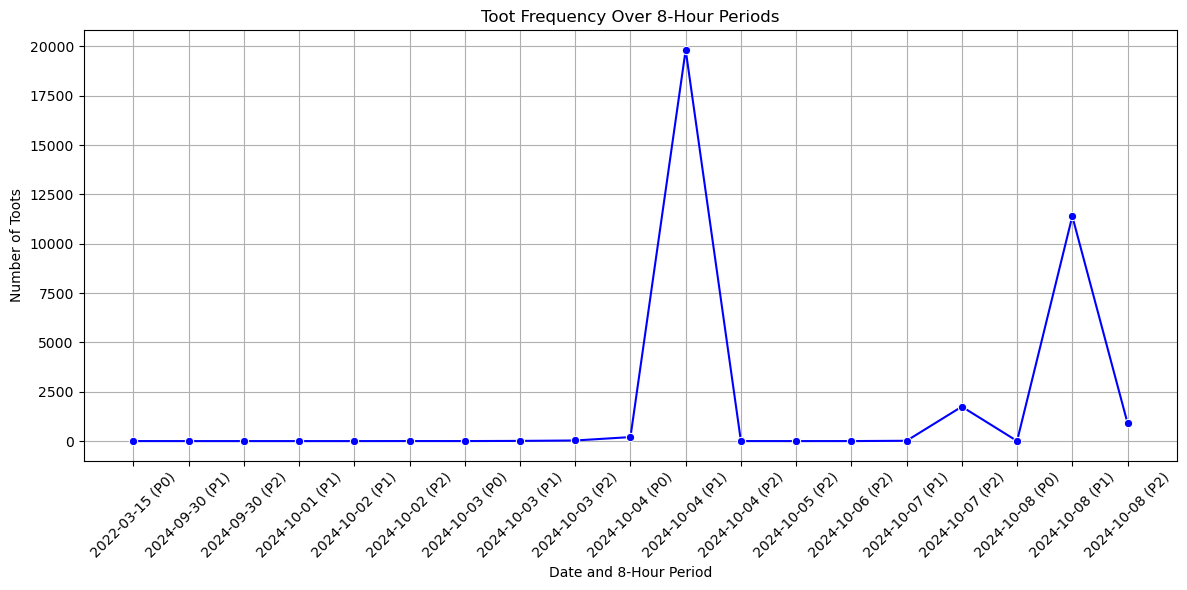

In [13]:
# Charger les données à partir de PostgreSQL
df_toots = spark.read.jdbc(url=jdbc_url, table="toots", properties=jdbc_properties)

# Ajouter une colonne pour les périodes de 8 heures
df_toots = df_toots.withColumn("period", (F.hour("timestamp") / 8).cast("int"))

# Grouper par date et période de 8 heures
df_frequency = df_toots \
    .withColumn("date", F.to_date("timestamp")) \
    .groupBy("date", "period") \
    .count() \
    .orderBy("date", "period")

# Convertir en Pandas pour visualisation
df_frequency_pd = df_frequency.toPandas()

# Créer une colonne "Date et période" pour un affichage clair
df_frequency_pd["date_period"] = df_frequency_pd["date"].astype(str) + " (P" + df_frequency_pd["period"].astype(str) + ")"

# Créer un graphique en ligne avec Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x="date_period", y="count", data=df_frequency_pd, marker="o", color="b")
plt.title("Toot Frequency Over 8-Hour Periods")
plt.xlabel("Date and 8-Hour Period")
plt.ylabel("Number of Toots")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Top Hashtags: Horizontal bar chart showing the most frequent hashtags in the dataset.

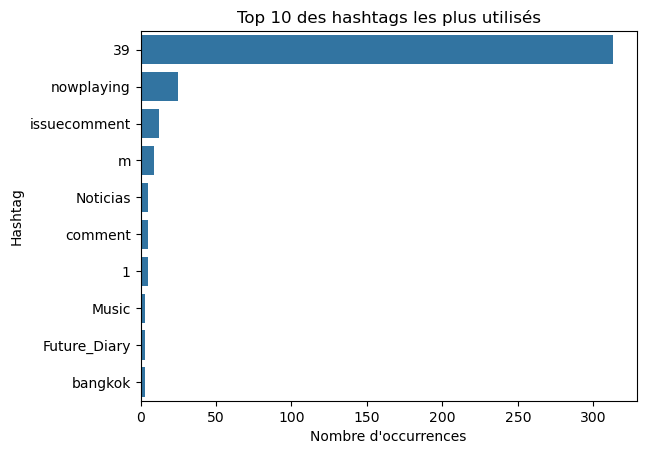

In [11]:
# Lire les données de Postgre
# Charger les données à partir de PostgreSQL
df_hashtags = spark.read.jdbc(url=jdbc_url, table="hashtags", properties=jdbc_properties)

hashtag_counts = df_hashtags.groupBy("hashtag").count().orderBy(F.col("count").desc()).limit(10).toPandas()

# Créer un graphique en barres horizontales
sns.barplot(x='count', y='hashtag', data=hashtag_counts)
plt.title("Top 10 des hashtags les plus utilisés")
plt.xlabel("Nombre d'occurrences")
plt.ylabel("Hashtag")
plt.show()


# User Activity: Heatmap showing user activity (toots per time window).


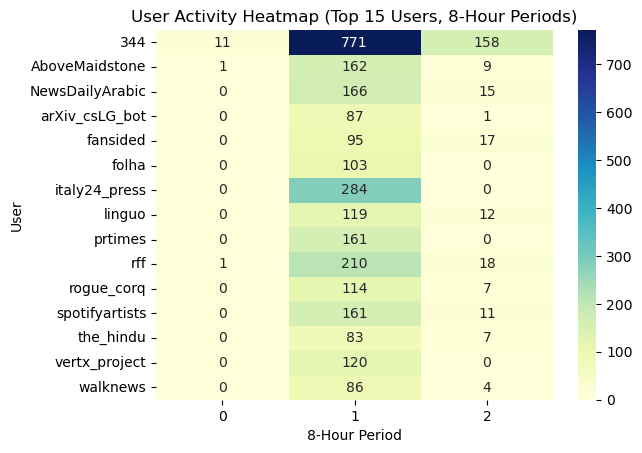

In [10]:
# Charger les données à partir de PostgreSQL
df_activity = spark.read.jdbc(url=jdbc_url, table="toots", properties=jdbc_properties)

# Ajouter une colonne pour les périodes de 8 heures
df_activity = df_activity.withColumn("period", (F.hour("timestamp") / 8).cast("int"))

# Calculer le nombre de toots par utilisateur et période de 8 heures
user_activity = df_activity \
    .groupBy("user", "period") \
    .count() \
    .orderBy(F.desc("count"))

# Identifier les 15 utilisateurs les plus actifs
top_users = user_activity \
    .groupBy("user") \
    .agg(F.sum("count").alias("total_toots")) \
    .orderBy(F.desc("total_toots")) \
    .limit(15)

# Filtrer l'activité pour ces 15 utilisateurs
user_activity_filtered = user_activity \
    .join(top_users, on="user", how="inner") \
    .select("user", "period", "count") \
    .toPandas()

# Créer une matrice utilisateur/période
user_activity_pivot = user_activity_filtered.pivot(index="user", columns="period", values="count").fillna(0)

# Créer une heatmap avec Seaborn
sns.heatmap(user_activity_pivot, cmap="YlGnBu", annot=True, fmt="g")
plt.title("User Activity Heatmap (Top 15 Users, 8-Hour Periods)")
plt.xlabel("8-Hour Period")
plt.ylabel("User")
plt.show()
